## Homework 3
From Chapter 4, found on pages 196-197 of ISLP

*This question should be answered using the `Weekly` data set, which is part of the ISLP package. This data is similar in nature to the Smarket data from this section's in-class exercises, except that it contains 1089 weekly returns for 21 years, from the beginning of 1990 to the end of 2010.*

In [1]:
# Import standard libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
import statsmodels.api as sm

# Import specific objects
from ISLP.models import (ModelSpec as MS,
                         summarize)
from ISLP import load_data
from ISLP import confusion_table
from ISLP.models import contrast
from sklearn.discriminant_analysis import \
     (LinearDiscriminantAnalysis as LDA,
      QuadraticDiscriminantAnalysis as QDA)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder

# Load dataset
Weekly = load_data('Weekly')
Weekly

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,1990,0.816,1.572,-3.936,-0.229,-3.484,0.154976,-0.270,Down
1,1990,-0.270,0.816,1.572,-3.936,-0.229,0.148574,-2.576,Down
2,1990,-2.576,-0.270,0.816,1.572,-3.936,0.159837,3.514,Up
3,1990,3.514,-2.576,-0.270,0.816,1.572,0.161630,0.712,Up
4,1990,0.712,3.514,-2.576,-0.270,0.816,0.153728,1.178,Up
...,...,...,...,...,...,...,...,...,...
1084,2010,-0.861,0.043,-2.173,3.599,0.015,3.205160,2.969,Up
1085,2010,2.969,-0.861,0.043,-2.173,3.599,4.242568,1.281,Up
1086,2010,1.281,2.969,-0.861,0.043,-2.173,4.835082,0.283,Up
1087,2010,0.283,1.281,2.969,-0.861,0.043,4.454044,1.034,Up


a) Produce some numerical and graphical summaries of the `Weekly` data. Do there appear to be any patterns?

In [2]:
# Display summary statistics of the Weekly dataset
summary_stats = Weekly.describe()
summary_stats


,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
count,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000
mean,2000.048669,0.150585,0.151079,0.147205,0.145818,0.139893,1.574618,0.149899
std,6.033182,2.357013,2.357254,2.360502,2.360279,2.361285,1.686636,2.356927
min,1990.000000,-18.195000,-18.195000,-18.195000,-18.195000,-18.195000,0.087465,-18.195000
25%,1995.000000,-1.154000,-1.154000,-1.158000,-1.158000,-1.166000,0.332022,-1.154000
50%,2000.000000,0.241000,0.241000,0.241000,0.238000,0.234000,1.002680,0.241000
75%,2005.000000,1.405000,1.409000,1.409000,1.409000,1.405000,2.053727,1.405000
max,2010.000000,12.026000,12.026000,12.026000,12.026000,12.026000,9.328214,12.026000


In [3]:
# Display the distribution of the 'Direction' variable
direction_counts = Weekly['Direction'].value_counts()
direction_counts


Direction
Up      605
Down    484
Name: count, dtype: int64

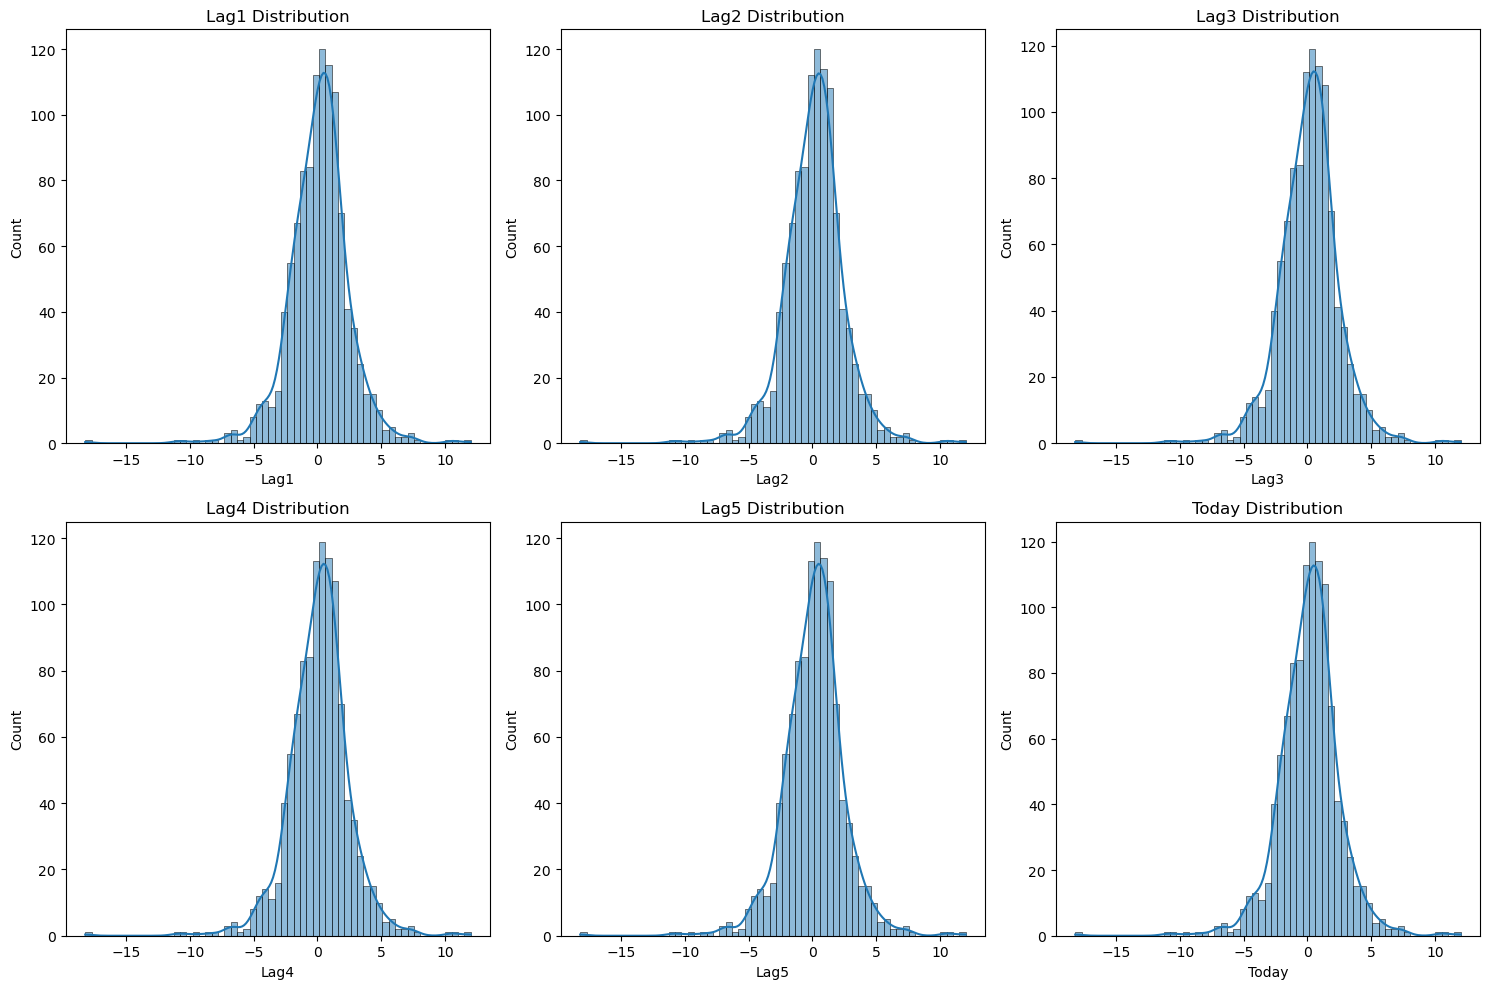

In [4]:
# Plot histograms of the return columns
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
sns.histplot(Weekly['Lag1'], kde=True, ax=axs[0, 0]).set_title('Lag1 Distribution')
sns.histplot(Weekly['Lag2'], kde=True, ax=axs[0, 1]).set_title('Lag2 Distribution')
sns.histplot(Weekly['Lag3'], kde=True, ax=axs[0, 2]).set_title('Lag3 Distribution')
sns.histplot(Weekly['Lag4'], kde=True, ax=axs[1, 0]).set_title('Lag4 Distribution')
sns.histplot(Weekly['Lag5'], kde=True, ax=axs[1, 1]).set_title('Lag5 Distribution')
sns.histplot(Weekly['Today'], kde=True, ax=axs[1, 2]).set_title('Today Distribution')
plt.tight_layout()
plt.show()


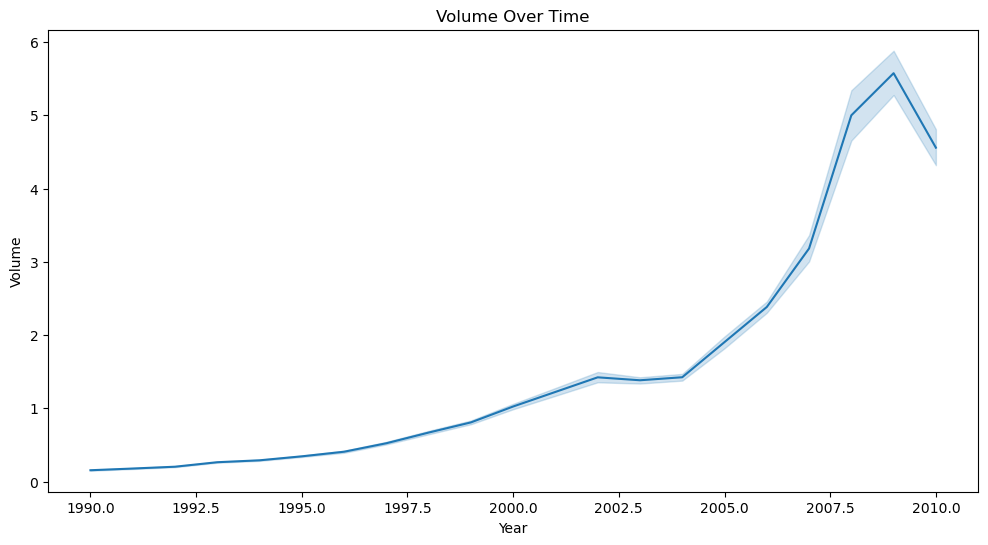

In [5]:
# Plot Volume over time
plt.figure(figsize=(12, 6))
sns.lineplot(x='Year', y='Volume', data=Weekly).set_title('Volume Over Time')
plt.show()


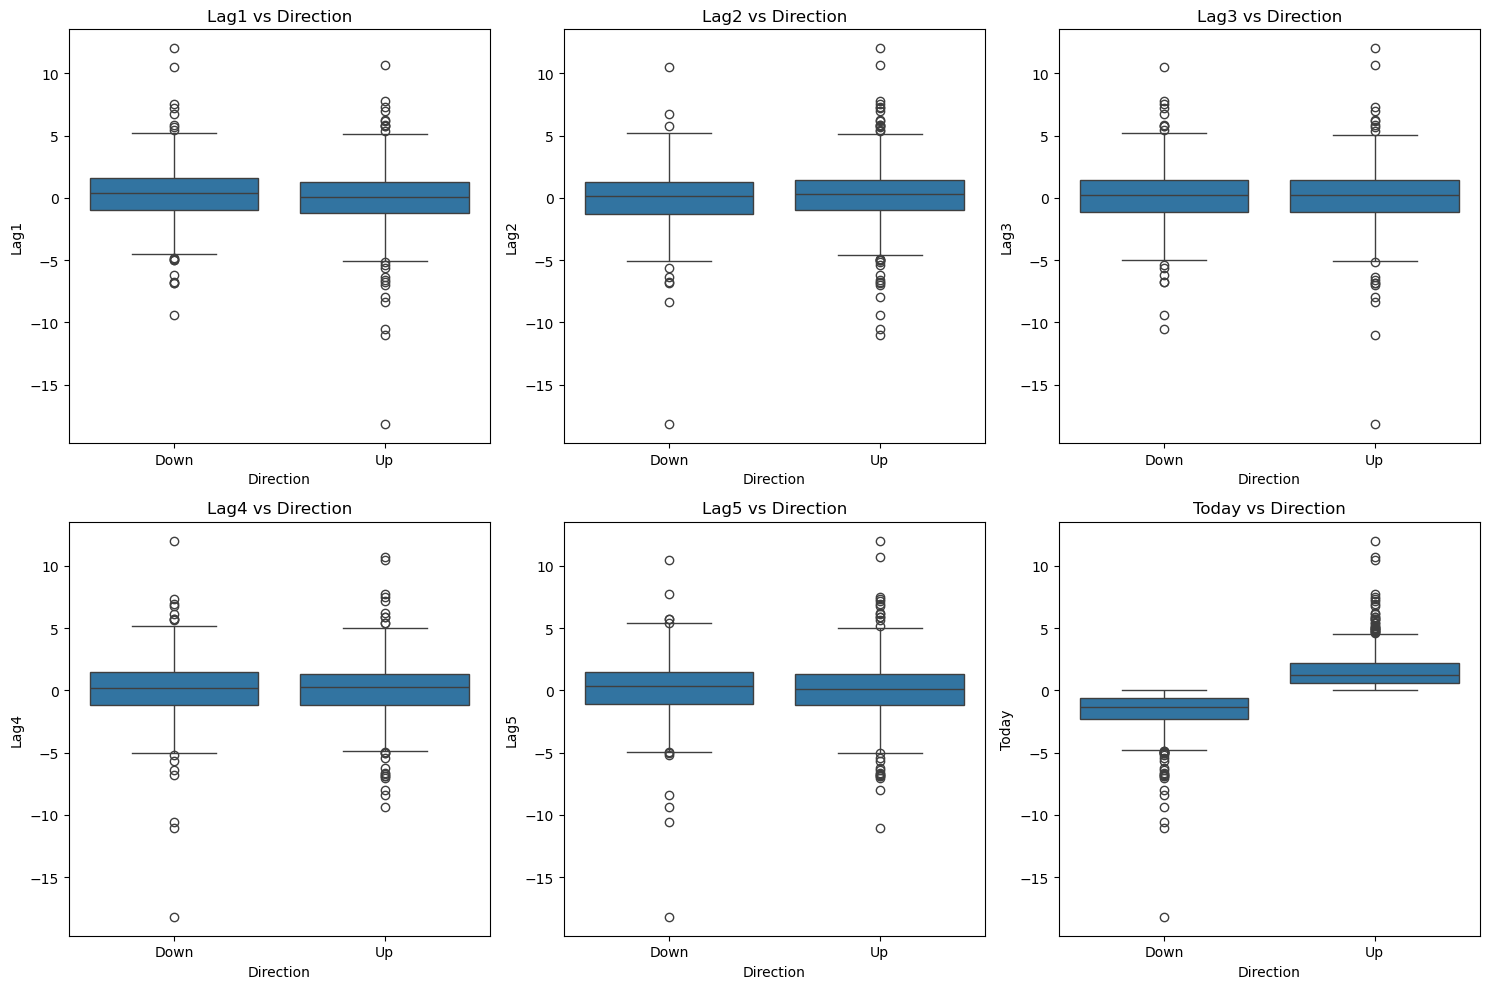

In [6]:
# Plot boxplots of returns vs. Direction
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
sns.boxplot(x='Direction', y='Lag1', data=Weekly, ax=axs[0, 0]).set_title('Lag1 vs Direction')
sns.boxplot(x='Direction', y='Lag2', data=Weekly, ax=axs[0, 1]).set_title('Lag2 vs Direction')
sns.boxplot(x='Direction', y='Lag3', data=Weekly, ax=axs[0, 2]).set_title('Lag3 vs Direction')
sns.boxplot(x='Direction', y='Lag4', data=Weekly, ax=axs[1, 0]).set_title('Lag4 vs Direction')
sns.boxplot(x='Direction', y='Lag5', data=Weekly, ax=axs[1, 1]).set_title('Lag5 vs Direction')
sns.boxplot(x='Direction', y='Today', data=Weekly, ax=axs[1, 2]).set_title('Today vs Direction')
plt.tight_layout()
plt.show()


b) Use the full data set to perform a logistic regression with Direction as the response and the five lag variables plus Volume as predictors. Do not forget to drop missing values due to lag creation. Use the summary function to print the results. Do any of the predictors appear to be statistically significant? If so, which ones?

In [9]:
# Convert the Direction categorical variable to numeric
Weekly['Direction'] = Weekly['Direction'].apply(lambda x: 1 if x == 'Up' else 0)

# Prepare the data by dropping any rows with missing values
Weekly = Weekly.dropna()

# Define the predictors and the response variable
X = Weekly[['Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume']]
y = Weekly['Direction']

# Add a constant to the predictors (intercept term)
X = sm.add_constant(X)

# Fit a logistic regression model
logit_model = sm.Logit(y, X).fit()

# Print the summary of the logistic regression model
logit_summary = logit_model.summary()
print(logit_summary)


Optimization terminated successfully.
         Current function value: 0.682441
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:              Direction   No. Observations:                 1089
Model:                          Logit   Df Residuals:                     1082
Method:                           MLE   Df Model:                            6
Date:                Mon, 10 Jun 2024   Pseudo R-squ.:                0.006580
Time:                        13:56:00   Log-Likelihood:                -743.18
converged:                       True   LL-Null:                       -748.10
Covariance Type:            nonrobust   LLR p-value:                    0.1313
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2669      0.086      3.106      0.002       0.098       0.435
Lag1          -0.0413      0.

In [11]:
allvars = Weekly.columns.drop(['Today', 'Direction', 'Year'])
design = MS(allvars)
X = design.fit_transform(Weekly)
y = Weekly.Direction == 'Up'
# fit the model
glm = sm.Logit(y, X)

# # or equally:
# glm = sm.GLM(y,
#              X,
#              family=sm.families.Binomial())
results = glm.fit()
summarize(results)

         Current function value: 0.000000
         Iterations: 35


c:\Users\User\miniconda3\envs\dsi_participant\lib\site-packages\ISLP\models\columns.py:159: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if is_categorical[i]:
c:\Users\User\miniconda3\envs\dsi_participant\lib\site-packages\statsmodels\discrete\discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
c:\Users\User\miniconda3\envs\dsi_participant\lib\site-packages\statsmodels\discrete\discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
c:\Users\User\miniconda3\envs\dsi_participant\lib\site-packages\statsmodels\discrete\discrete_model.py:227: PerfectSeparat

,coef,std err,z,P>|z|
intercept,-24.2352,6250.663,-0.004000,0.997
Lag1,-0.3446,885.229,-0.000000,1.000
Lag2,-0.3909,1255.733,-0.000000,1.000
Lag3,-0.2724,1547.862,-0.000000,1.000
Lag4,-0.1033,2103.248,-0.000049,1.000
Lag5,0.1072,2090.868,0.000051,1.000
Volume,-0.4375,3025.729,-0.000000,1.000


c) Compute the confusion matrix and overall fraction of correct predictions. Explain what the confusion matrix is telling you about the types of mistakes made by logistic regression

In [12]:
X = design.fit_transform(Weekly)
X_train, X_test = X.loc[train], X.loc[~train]

D = Weekly.Direction
L_train, L_test = D.loc[train], D.loc[~train]

knn1 = KNeighborsClassifier(n_neighbors=1) # API reference: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
X_train, X_test = [np.asarray(X) for X in [X_train, X_test]]
knn1.fit(X_train, L_train)
knn1_pred = knn1.predict(X_test)
confusion_table(knn1_pred, L_test)

c:\Users\User\miniconda3\envs\dsi_participant\lib\site-packages\ISLP\models\columns.py:159: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if is_categorical[i]:


Truth,0,1
Predicted,,
0,69,92
1,72,80


d) Now fit the logistic regression model using a training data period from 1990 to 2008, with Lag2 as the only predictor. Compute the confusion matrix and the overall fraction of correct predictions for the held out data (that is, the data from 2009 and 2010).

In [ ]:
#Add your code here

e) Use KNN with K = 1.

In [ ]:
#Add your code here

Additional Practice Questions: 
- Explain the difference between MLR and OLS to a non-technical audience. 
- How would you describe this exercise in an interview to both a technical and non-technical interviewer?
- What are the key insights you would want to show? 
- Can you think of a business context where this exercise would have applications?